In [115]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pytesseract
import re

In [116]:
image_file = "powder3.jpg"
img = cv2.imread(image_file)

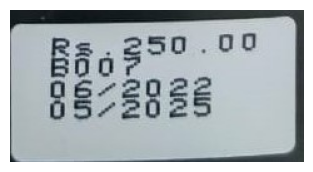

In [117]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    
    if len(im_data.shape) == 2: 
        height, width = im_data.shape
        figsize = width / float(dpi), height / float(dpi)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(im_data, cmap='gray')
    else:  
        height, width, depth = im_data.shape
        figsize = width / float(dpi), height / float(dpi)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(im_data)

    plt.show()

display(image_file)


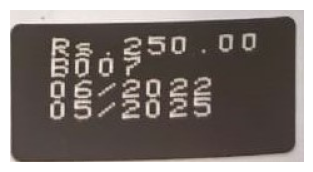

In [118]:
# to invert the image 
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("inverted.png", inverted_image)
display("inverted.png")

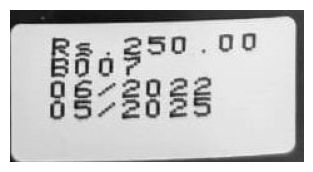

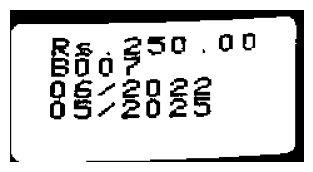

In [119]:
#Binarization
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_image = grayscale(img)
cv2.imwrite("gray.png", gray_image)
display("gray.png")

thresh , im_bw = cv2.threshold(gray_image, 130, 255, cv2.THRESH_BINARY)
cv2.imwrite("im_bw.png" , im_bw)
display("im_bw.png")

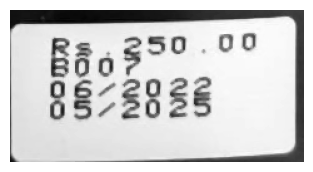

In [120]:
#Noise Removal
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1,1), np.uint8)
    image = cv2.dilate(image,kernel,iterations=1)
    kernel = np.ones((1,1),np.uint8)
    image = cv2.erode(image , kernel, iterations=1)
    image = cv2.morphologyEx(image , cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image , 3)
    return(image)

no_noise = noise_removal(gray_image)
cv2.imwrite("noise.png" , no_noise)
display("noise.png")

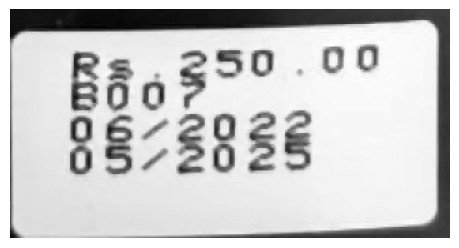

In [121]:
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    return resized_image

resized_image = resize_image(no_noise, 150)
cv2.imwrite("resized.png", resized_image)
display("resized.png")


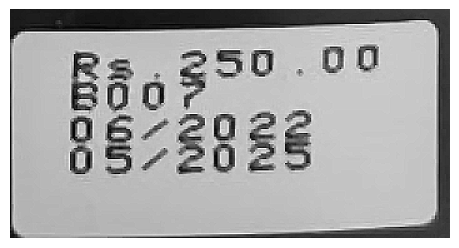

In [122]:
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]]) 
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

sharpened_image = sharpen_image(resized_image)
cv2.imwrite("sharpened.png", sharpened_image)
display("sharpened.png")


In [125]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

ocr_text = pytesseract.image_to_string(image_file) 

print("Extracted Text:\n", ocr_text)


Extracted Text:
  



In [124]:
import re
from datetime import datetime

date_pattern = r'\b(?:[@#]?\s*(\d{4}-\d{2}-\d{2}|\d{2}[/-]\d{2}[/-]\d{2,4}|\d{4}[/-]\d{2}[/-]\d{2}|\d{1,2} [a-zA-Z]{3,9} \d{4}|\d{1,2} [a-zA-Z]{3,9},? \d{4}|\d{1,2}[a-zA-Z]{0,3} \d{4}|\d{4} [a-zA-Z]{3,9}|\d{4}[/-]\d{2}|\d{4} [a-zA-Z]{3,9}|\d{1,2}[a-zA-Z]{0,3}[,]? \d{4}|\d{1,2}[/-][a-zA-Z]{3}[/-]\d{2,4}|\d{4}-\d{3}|\@?\s*\d{2}[/-]\d{2}))\b'
mrp_pattern = r'(?i)\b(?:₹|Rs\.?|INR)?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{1,2})?)\s*(?:incl(?:uding)?|Inclusive|Plus|Extra|Not Included|Taxes|VAT|GST|Cess)?(?:\s*(?:of)?\s*(?:all)?\s*(?:taxes|VAT|GST|Cess|Service\s*Tax))?\b'

def process_ocr_text(text):
    date_matches = re.findall(date_pattern, text)
    date_objs = []
    
    if date_matches:
        for date in date_matches:
            if '/' in date or '-' in date:
                if len(date.split('/')[-1]) == 2 or len(date.split('-')[-1]) == 2:
                    date = date.replace(date.split('/')[-1], '20' + date.split('/')[-1]) if '/' in date else date.replace(date.split('-')[-1], '20' + date.split('-')[-1])
   
            try:
                if '/' in date:
                    if date.startswith('@'):
                        month, year = map(int, date[1:].split('/'))
                        date_obj = datetime(year, month, 1)  
                    else:
                        date_obj = datetime.strptime(date, '%d/%m/%Y')
                else:
                    date_obj = datetime.strptime(date, '%d/%m/%Y')
                date_objs.append(date_obj)
            except ValueError:
                try:
                    date_obj = datetime.strptime(date, '%m/%Y')
                    date_objs.append(date_obj)
                except ValueError:
                    continue

    if date_objs:
        expiration_date = sorted(date_objs)[-1].strftime('%m/%Y')
    else:
        expiration_date = 'Not found'

    mrp_match = re.search(mrp_pattern, text)
    mrp = 'Not found' if not mrp_match else mrp_match.group(1).strip()

    return expiration_date, mrp

extracted_text = ocr_text
expiration, mrp = process_ocr_text(extracted_text)


print(f"Expiration Date: {expiration}")
print(f"MRP: {mrp}")


Expiration Date: Not found
MRP: Not found
